In [ ]:
import cv2
import os
from geocalib import viz2d
import matplotlib.pyplot as plt
import numpy as np

image_path="/media/shuo/T7/duslam/iphone/aass/rgb/frame00004.jpg"
image = cv2.imread(image_path)
# image to RGB
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# calibrate the image
calib_txt='/home/shuo/projects/shuo/computer_vision/DROID-SLAM/calib/iphone.txt'
K = np.eye(3)
calib = np.loadtxt(calib_txt, delimiter=" ")
fx, fy, cx, cy = calib[:4]
K[0,0] = fx
K[0,2] = cx
K[1,1] = fy
K[1,2] = cy
if len(calib) > 4:
    image_distort = cv2.undistort(image, K, calib[4:])

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_distort = cv2.cvtColor(image_distort, cv2.COLOR_BGR2RGB)
show_images = [image, image_distort]
fig = viz2d.plot_images([im for im in show_images])
plt.show()

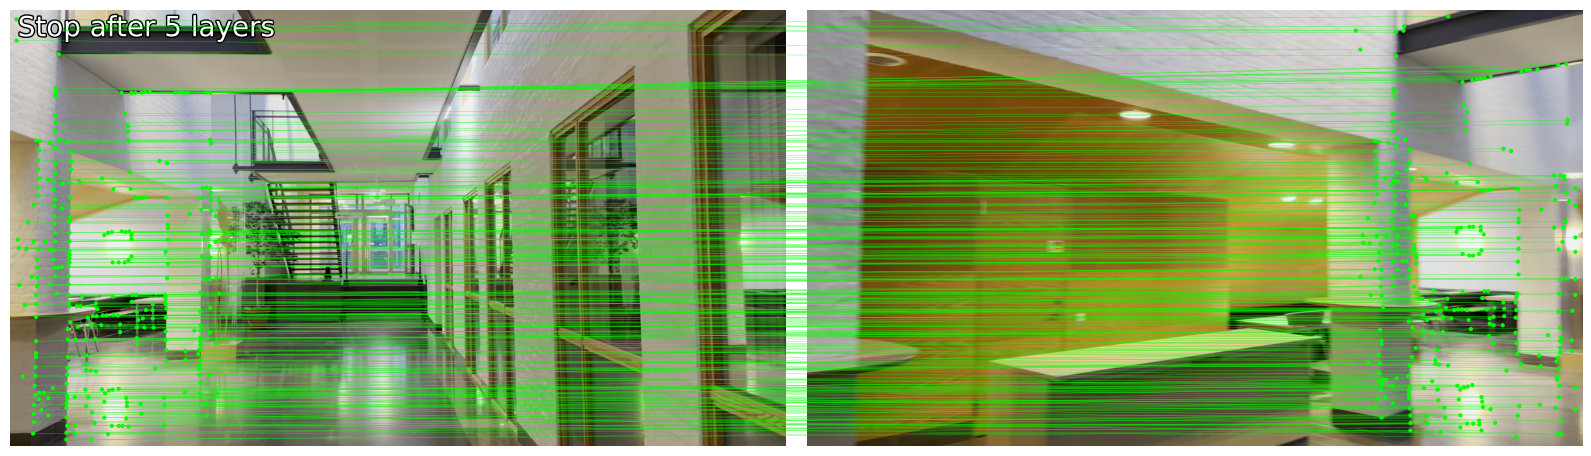

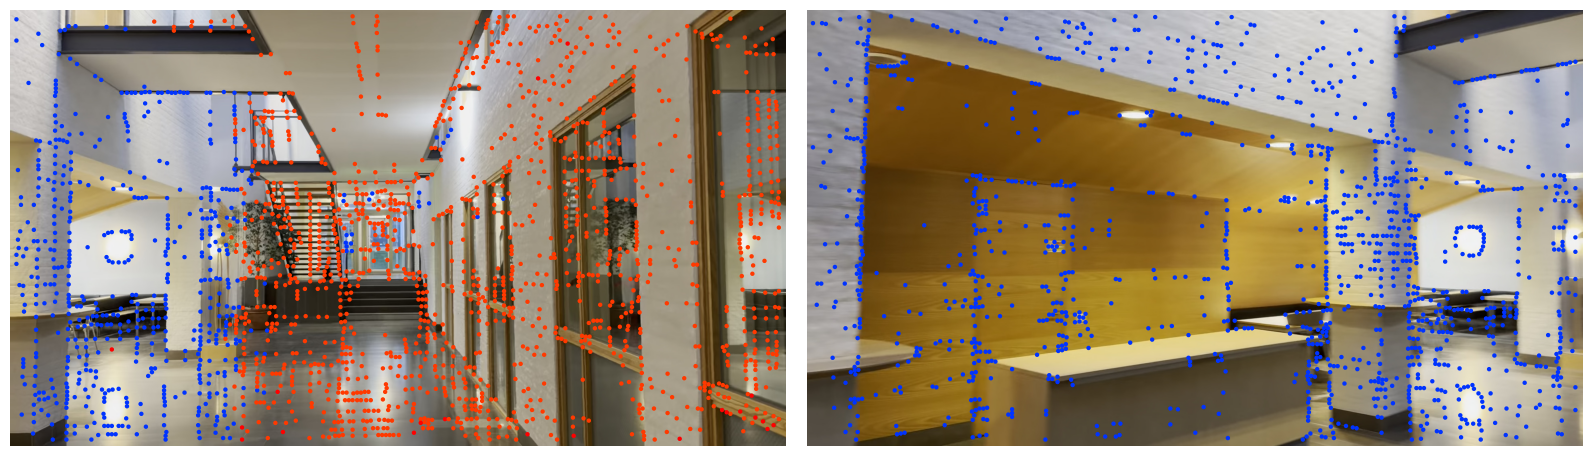

In [1]:
from PIL import Image, ImageOps
import pycolmap
from lightglue  import viz2d
import numpy as np
from lightglue import LightGlue, SuperPoint, DISK, SIFT
from lightglue.utils import load_image, rbd
import torch

image_path1 = "/media/shuo/T7/duslam/iphone/aass/rgb/frame00001.jpg"
image_path2 = "/media/shuo/T7/duslam/iphone/aass/rgb/frame00024.jpg"

image0 = load_image(image_path1)
image1 = load_image(image_path2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)